# Exploratory data analysis

In [1]:
import pandas as pd

In [2]:
df_data = pd.read_csv("../data/training.csv")

In [3]:
df_data['TransactionStartTime'] = pd.to_datetime(df_data['TransactionStartTime'],dayfirst=True)

C:\Users\FADELCO\AppData\Local\Temp\ipykernel_23460\493135403.py:1: UserWarning: Parsing dates in %Y-%m-%dT%H:%M:%S%z format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_data['TransactionStartTime'] = pd.to_datetime(df_data['TransactionStartTime'],dayfirst=True)


In [56]:
# Time Coverage
df_data['TransactionStartTime'].iloc[-1] - df_data['TransactionStartTime'].iloc[0]

Timedelta('90 days 07:42:39')

## Understand features

In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   TransactionId         95662 non-null  object             
 1   BatchId               95662 non-null  object             
 2   AccountId             95662 non-null  object             
 3   SubscriptionId        95662 non-null  object             
 4   CustomerId            95662 non-null  object             
 5   CurrencyCode          95662 non-null  object             
 6   CountryCode           95662 non-null  int64              
 7   ProviderId            95662 non-null  object             
 8   ProductId             95662 non-null  object             
 9   ProductCategory       95662 non-null  object             
 10  ChannelId             95662 non-null  object             
 11  Amount                95662 non-null  float64            
 12  Valu

In [6]:
df_data.nunique()/len(df_data)

TransactionId           1.000000
BatchId                 0.991083
AccountId               0.037977
SubscriptionId          0.037915
CustomerId              0.039117
CurrencyCode            0.000010
CountryCode             0.000010
ProviderId              0.000063
ProductId               0.000240
ProductCategory         0.000094
ChannelId               0.000042
Amount                  0.017520
Value                   0.015858
TransactionStartTime    0.988438
PricingStrategy         0.000042
FraudResult             0.000021
dtype: float64

In [7]:
df_data.nunique()

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
CurrencyCode                1
CountryCode                 1
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1676
Value                    1517
TransactionStartTime    94556
PricingStrategy             4
FraudResult                 2
dtype: int64

In [8]:
columns_to_drop = ['BatchId','CurrencyCode','CountryCode']

### Understand CustomerId, accountId, SubscriptionId

In [9]:
identifiers = ['SubscriptionId','AccountId','CustomerId']

In [10]:
df_data[identifiers].nunique()

SubscriptionId    3627
AccountId         3633
CustomerId        3742
dtype: int64

In [11]:
df_data.groupby(identifiers[:-1]).nunique()[identifiers[-1:]]

,,CustomerId
SubscriptionId,AccountId,
SubscriptionId_10,AccountId_2708,1
SubscriptionId_1000,AccountId_3421,1
SubscriptionId_1001,AccountId_1297,1
SubscriptionId_1002,AccountId_1344,1
SubscriptionId_1004,AccountId_4474,1
...,...,...
SubscriptionId_993,AccountId_4674,1
SubscriptionId_995,AccountId_3226,1
SubscriptionId_997,AccountId_2575,1


In [12]:
# subscriptionId and AccountID are not sufficient to identify a unique person doing a transaction

(df_data.groupby(identifiers[:-1]).nunique()[identifiers[-1:]]>1).sum()

CustomerId    10
dtype: int64

In [13]:
df_data.groupby(identifiers[1:]).nunique()[identifiers[:1]]

SubscriptionId
AccountId     CustomerId                     
AccountId_1   CustomerId_46                 1
AccountId_10  CustomerId_1074               1
              CustomerId_1093               1
              CustomerId_1096               1
              CustomerId_1156               1
...                                       ...
AccountId_99  CustomerId_420                1
AccountId_990 CustomerId_1339               1
AccountId_992 CustomerId_1341               1
AccountId_994 CustomerId_1343               1
AccountId_998 CustomerId_1349               1

[8222 rows x 1 columns]

In [14]:
# We can drop the ``subscriptionId`` column if we keep both ``AccountId`` and ``CustomerId``

(df_data.groupby(identifiers[1:]).nunique()[identifiers[:1]]>1).sum()

SubscriptionId    0
dtype: int64

In [15]:
df_data.groupby(['SubscriptionId','CustomerId']).nunique()['AccountId']

SubscriptionId       CustomerId     
SubscriptionId_10    CustomerId_3128    1
SubscriptionId_1000  CustomerId_3855    1
SubscriptionId_1001  CustomerId_1659    1
SubscriptionId_1002  CustomerId_1707    1
SubscriptionId_1004  CustomerId_4934    1
                                       ..
SubscriptionId_993   CustomerId_5142    1
SubscriptionId_995   CustomerId_3654    1
SubscriptionId_997   CustomerId_2992    1
SubscriptionId_998   CustomerId_4636    1
SubscriptionId_999   CustomerId_1210    1
Name: AccountId, Length: 6545, dtype: int64

In [16]:
# subscriptionId and CustomerId are not sufficient to identify a unique person doing a transaction
(df_data.groupby(['SubscriptionId','CustomerId']).nunique()[['AccountId']] > 1).sum()

AccountId    1677
dtype: int64

In [17]:
# discard 'SubscriptionId' column
columns_to_drop.append('SubscriptionId')

## Train-test split

The train-test split should be done in a way that we have different customers in the training and test set


In [6]:
from fraudetect.helpers import get_train_test_set, get_train_delay_test_set, prequentialSplit
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# renaming columns
rename_cols = {
    'FraudResult': 'TX_FRAUD',
    'Amount': 'TX_AMOUNT',
    'CustomerId': 'CUSTOMER_ID',
    'TransactionStartTime': 'TX_DATETIME',
    'TransactionId': 'TRANSACTION_ID',
}

df_data.rename(columns=rename_cols, inplace=True)
df_data.columns

Index(['TRANSACTION_ID', 'BatchId', 'AccountId', 'SubscriptionId',
       'CUSTOMER_ID', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'TX_AMOUNT', 'Value', 'TX_DATETIME',
       'PricingStrategy', 'TX_FRAUD', 'TX_TIME_DAYS'],
      dtype='object')

In [7]:
# create TX_TIME_DAYS column
df_data['TX_TIME_DAYS'] = (df_data['TX_DATETIME'] - df_data['TX_DATETIME'].min()).dt.days

# create TX_TIME_SECONDS column
# df_data['TX_TIME_SECONDS'] = (df_data['TX_DATETIME'] - df_data['TX_DATETIME'].min()).dt.seconds

In [8]:
# df_data.set_index('TX_DATETIME',inplace=True)
df_data.sort_values('TX_DATETIME',inplace=True,ascending=True)

In [9]:
df_data_copy = df_data.copy()
df_data_copy['Fraud_cumsum'] = df_data_copy['TX_FRAUD'].cumsum()

<Axes: title={'center': 'Fraud over time'}, xlabel='TX_DATETIME'>

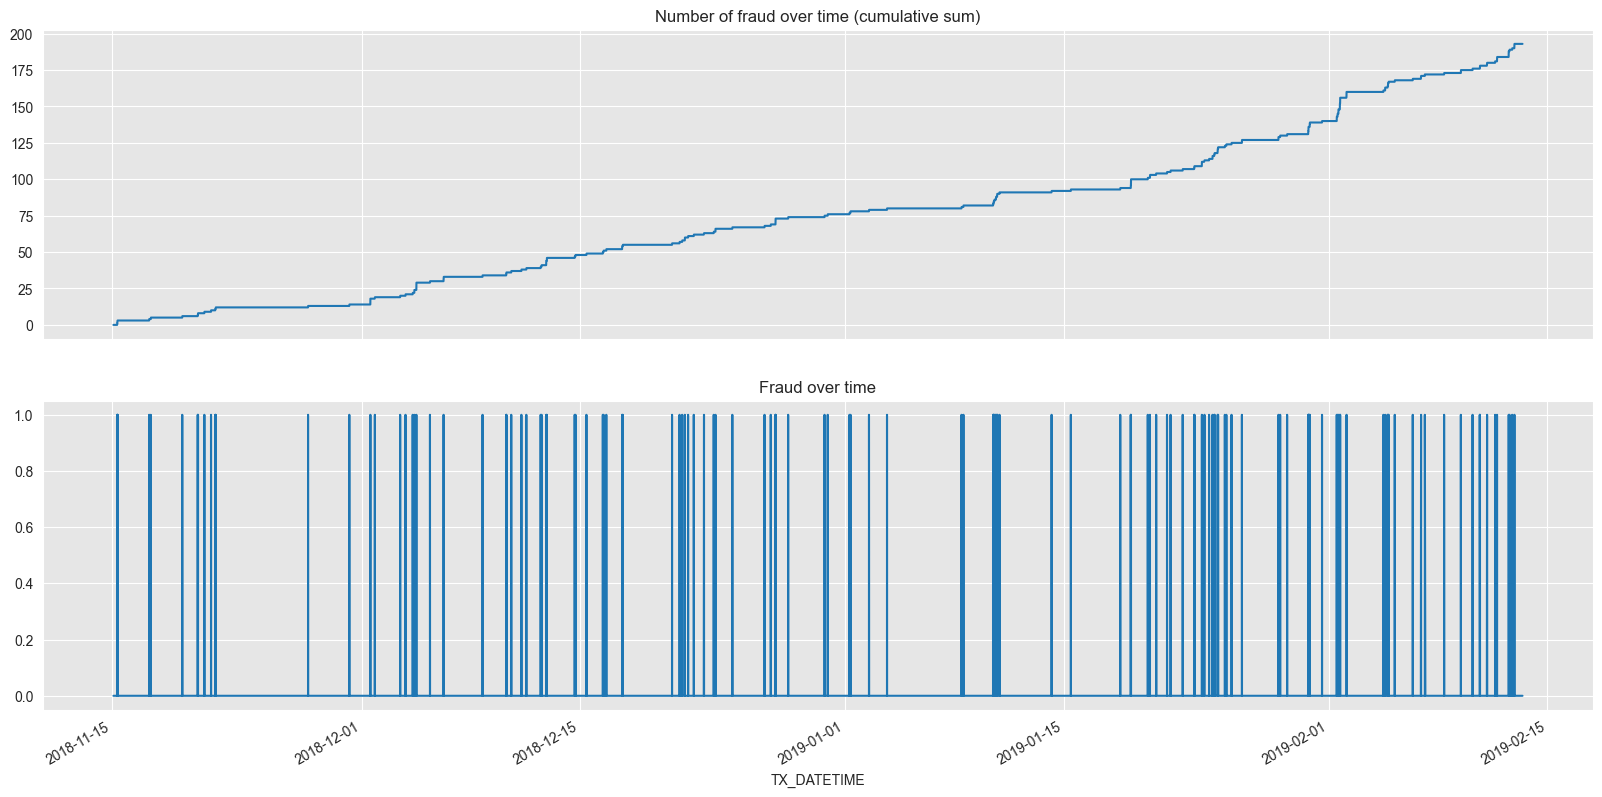

In [10]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
df_data_copy.plot(ax=axes[0], x='TX_DATETIME', y='Fraud_cumsum', title='Number of fraud over time (cumulative sum)', legend=False)

df_data_copy.plot(ax=axes[1], x='TX_DATETIME', y='TX_FRAUD', title='Fraud over time', legend=False)

In [11]:
# Set the starting day for the training period, and the deltas
start_date_training = df_data['TX_DATETIME'].iloc[0]
delta_train=62
delta_delay=7
delta_test=21

train_df, test_df = get_train_test_set(df_data,
                                    start_date_training=start_date_training,
                                    delta_train=delta_train,
                                    delta_test=delta_test,
                                    delta_delay=delta_delay,
                                    sampling_ratio=1.0
                                    )

In [12]:
# number of samples
train_df.shape[0], test_df.shape[0]

(61407, 25932)

In [13]:
# number of positive samples
train_df[train_df.TX_FRAUD==1].shape[0], test_df[test_df.TX_FRAUD==1].shape[0]

(93, 82)

In [14]:
# ratio of positive samples in Train set
round(train_df[train_df.TX_FRAUD==1].shape[0]/train_df.shape[0], 6)

0.001514

In [15]:
# ratio of positive samples in Test set
round(test_df[test_df.TX_FRAUD==1].shape[0]/test_df.shape[0], 6)

0.003162

In [16]:
# customers overlap between train and test set
customers_intersec = np.intersect1d(train_df['CUSTOMER_ID'].unique(), test_df['CUSTOMER_ID'].unique())
customers_intersec.shape

(893,)

In [17]:
# unique customers to train set
customers_unique_to_train = [a for a in train_df['CUSTOMER_ID'].unique() if a not in customers_intersec]
len(customers_unique_to_train), len(customers_unique_to_train)/len(train_df['CUSTOMER_ID'].unique())

(1870, 0.6768005790807093)

In [18]:
# unique customers to test set
customers_unique_to_test = [a for a in test_df['CUSTOMER_ID'].unique() if a not in customers_intersec]
len(customers_unique_to_test), len(customers_unique_to_test)/len(test_df['CUSTOMER_ID'].unique())

(865, 0.4920364050056883)

# Feature engineering

In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [20]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.TX_DATETIME
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW
    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID
        
    # And return the dataframe with the new features
    return customer_transactions


def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="AccountId"):
    
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    terminal_transactions.index=terminal_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions

In [123]:
def clean_data(df_data: pd.DataFrame,) -> pd.DataFrame:
    """
    Clean the data by dropping NA rows and duplicated rows
    """
    df = df_data.copy()
    df.drop_duplicates(inplace=True)
    df.dropna(axis=0,how='any',inplace=True)

    return df

def perform_feature_engineering(transactions_df, 
                                columns_to_drop:list, 
                                columns_to_onehot_encode:list,
                                onehot_encoder:OneHotEncoder,
                                scaler:StandardScaler,
                                windows_size_in_days=[1,7,30],
                                delay_period_accountid:int=7,
                                columns_to_scale:list=None,
                                mode:str='train'
                            )->pd.DataFrame:
    """
    Feature engineering function to be used in the pipeline.
    """

    assert mode in ['train','test','val'], "Error: mode should be either 'train' or 'test' or 'val'"

    df_data = clean_data(transactions_df)

    # create TX_TIME_DAYS column
    df_data['TX_TIME_DAYS'] = (df_data['TX_DATETIME'] - df_data['TX_DATETIME'].min()).dt.days

    # TX_DURING_WEEKEND
    df_data['TX_DURING_WEEKEND'] = (df_data['TX_DATETIME'].dt.dayofweek > 4)*1

    # TX_DURING_NIGHT
    df_data['TX_DURING_NIGHT'] = (df_data['TX_DATETIME'].dt.hour < 6)*1

    # Customer ID transformation
    df_data=df_data.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=windows_size_in_days))
    df_data=df_data.sort_values('TX_DATETIME').reset_index(drop=True)

    # Account ID transformation
    df_data=df_data.groupby('AccountId').apply(lambda x: get_count_risk_rolling_window(x, delay_period=delay_period_accountid,
                                                                                    windows_size_in_days=windows_size_in_days,
                                                                                    feature="AccountId"))
    df_data=df_data.sort_values('TX_DATETIME').reset_index(drop=True)

    # Features
    X = df_data.drop(columns=['TX_FRAUD'])

    # Labels
    y = df_data['TX_FRAUD']

    # get features for scaling and encoding
    X_one_hot = X[columns_to_onehot_encode].astype(str)

    if columns_to_scale is None:
        X_scale = X.drop(columns=columns_to_onehot_encode + columns_to_drop).astype(float)
        columns_to_scale = []
    else:
        X_scale = X[columns_to_scale].astype(float)

    # drop the columns that are not needed anymore
    X.drop(columns=columns_to_onehot_encode + columns_to_scale + columns_to_drop, inplace=True)

    if mode == 'train':
        # Fit on the training data
        X_one_hot = onehot_encoder.fit_transform(X_one_hot)
        X_scaled = scaler.fit_transform(X_scale)
        assert len(onehot_encoder.categories_) == len(columns_to_onehot_encode), "Error: Number of categories in one-hot encoder does not match the number of columns to one-hot encode. Set drop=None in the encoder."
        assert df_data.nunique().loc[columns_to_onehot_encode].sum() == X_one_hot.shape[1], "Error: Number of unique values in one-hot encoded columns does not match the number of columns to one-hot encode."
    
    else:
        # Transform the test/val data 
        X_one_hot = onehot_encoder.transform(X_one_hot)
        X_scaled = scaler.transform(X_scale)

    
    # Concatenate the one-hot encoded features with the scaled features
    if X.empty:
        X_preprocessed = np.hstack([X_one_hot, X_scaled])
    else:
        X_preprocessed = np.hstack([X_one_hot, X_scaled, X.to_numpy()])

    # check total numer of features    


    return X_preprocessed, y

def transform_data(train_df:pd.DataFrame, val_df:pd.DataFrame|None,
                   columns_to_drop:str,
                   columns_to_onehot_encode:str,
                   columns_to_scale:str,
                   windows_size_in_days=[1,7,30])->tuple:

    # scaler and encoders
    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop=None, dtype=np.float64)
    scaler = StandardScaler()

    X_train, y_train = perform_feature_engineering(train_df, 
                                               columns_to_drop=columns_to_drop,
                                               columns_to_onehot_encode=columns_to_onehot_encode,
                                               columns_to_scale=columns_to_scale,
                                               onehot_encoder=onehot_encoder,
                                               scaler=scaler,
                                               mode='train',
                                               windows_size_in_days=windows_size_in_days)
    if val_df is None:
        return (X_train, y_train), (onehot_encoder, scaler)
    
    X_val, y_val = perform_feature_engineering(val_df, 
                                               columns_to_drop=columns_to_drop,
                                               columns_to_onehot_encode=columns_to_onehot_encode,
                                               columns_to_scale=columns_to_scale,
                                               onehot_encoder=onehot_encoder,
                                               scaler=scaler,
                                               mode='val',
                                               windows_size_in_days=windows_size_in_days)
    
    return (X_train, y_train, X_val, y_val), (onehot_encoder, scaler)

## Preprocessing

In [22]:
df_data.head(3)

,TRANSACTION_ID,BatchId,AccountId,SubscriptionId,CUSTOMER_ID,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,TX_AMOUNT,Value,TX_DATETIME,PricingStrategy,TX_FRAUD,TX_TIME_DAYS
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0,0


In [120]:
df_data.nunique()

TRANSACTION_ID     95662
BatchId            94809
AccountId           3633
SubscriptionId      3627
CUSTOMER_ID         3742
CurrencyCode           1
CountryCode            1
ProviderId             6
ProductId             23
ProductCategory        9
ChannelId              4
TX_AMOUNT           1676
Value               1517
TX_DATETIME        94556
PricingStrategy        4
TX_FRAUD               2
TX_TIME_DAYS          91
dtype: int64

In [ ]:
COLUMNS_TO_DROP = ['CurrencyCode','CountryCode','SubscriptionId','BatchId','CUSTOMER_ID','AccountId','TRANSACTION_ID','TX_DATETIME','TX_TIME_DAYS']
COLUMNS_TO_ONE_HOT_ENCODE = ['PricingStrategy','ChannelId', 'ProductCategory', 'ProviderId', 'ProductId']
COLUMNS_TO_SCALE = ['TX_DURING_WEEKEND','TX_DURING_NIGHT','TX_AMOUNT','Value'] # or None to select all numeric columns

In [25]:
df_data.nunique().loc[COLUMNS_TO_ONE_HOT_ENCODE].sum()

np.int64(46)

In [26]:
train_df.columns

Index(['TRANSACTION_ID', 'BatchId', 'AccountId', 'SubscriptionId',
       'CUSTOMER_ID', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'TX_AMOUNT', 'Value', 'TX_DATETIME',
       'PricingStrategy', 'TX_FRAUD', 'TX_TIME_DAYS'],
      dtype='object')

In [ ]:
(X_train, y_train),(onehot_encoder, scaler) = transform_data(train_df=train_df, 
                                                            val_df=None,
                                                            columns_to_drop=COLUMNS_TO_DROP,
                                                            columns_to_onehot_encode=COLUMNS_TO_ONE_HOT_ENCODE,
                                                            columns_to_scale=COLUMNS_TO_SCALE,
                                                            windows_size_in_days=[1,7,30])

In [125]:
X_train.shape, X_train.dtype

((61407, 62), dtype('float64'))

In [58]:
onehot_encoder.categories_

[array(['0', '1', '2', '4'], dtype=object),
 array(['ChannelId_1', 'ChannelId_2', 'ChannelId_3', 'ChannelId_5'],
       dtype=object),
 array(['airtime', 'data_bundles', 'financial_services', 'movies', 'other',
        'ticket', 'transport', 'tv', 'utility_bill'], dtype=object),
 array(['ProviderId_1', 'ProviderId_2', 'ProviderId_3', 'ProviderId_4',
        'ProviderId_5', 'ProviderId_6'], dtype=object),
 array(['ProductId_1', 'ProductId_10', 'ProductId_11', 'ProductId_12',
        'ProductId_13', 'ProductId_14', 'ProductId_15', 'ProductId_16',
        'ProductId_19', 'ProductId_2', 'ProductId_20', 'ProductId_21',
        'ProductId_22', 'ProductId_23', 'ProductId_24', 'ProductId_27',
        'ProductId_3', 'ProductId_4', 'ProductId_5', 'ProductId_6',
        'ProductId_7', 'ProductId_8', 'ProductId_9'], dtype=object)]

In [ ]:
def load_data(data_path:str="../data/training.csv") -> pd.DataFrame:
    
    # load data
    df_data = pd.read_csv(data_path)
    df_data['TransactionStartTime'] = pd.to_datetime(df_data['TransactionStartTime'],dayfirst=True)
    # renaming columns
    rename_cols = {
        'FraudResult': 'TX_FRAUD',
        'Amount': 'TX_AMOUNT',
        'CustomerId': 'CUSTOMER_ID',
        'TransactionStartTime': 'TX_DATETIME',
        'TransactionId': 'TRANSACTION_ID',
    }
    df_data.rename(columns=rename_cols, inplace=True)

    # necessary for splitting
    df_data['TX_TIME_DAYS'] = (df_data['TX_DATETIME'] - df_data['TX_DATETIME'].min()).dt.days

    return df_data

def train_test_split(df_data:pd.DataFrame, 
                    delta_train:int=40, 
                    delta_delay:int=7, 
                    delta_test:int=20,
                    method:str='hold-out',
                    random_state:int=41,
                    n_folds:int=5,
                    sampling_ratio:float=1.0)->tuple:
    
    df_data.sort_values('TX_DATETIME',inplace=True,ascending=True)
    start_date_training = df_data['TX_DATETIME'].iloc[-1] # last date of the dataset
    start_date_training_with_valid = start_date_training + datetime.timedelta(days=-(delta_delay + delta_test + delta_train))
    
    if method == 'hold-out':
        train_df, test_df = get_train_test_set(df_data,
                                            start_date_training=start_date_training_with_valid,
                                            delta_train=delta_train,
                                            delta_test=delta_test,
                                            delta_delay=delta_delay,
                                            sampling_ratio=sampling_ratio,
                                            random_state=random_state
                                            )
        
        return train_df, test_df 
    
    elif method == 'prequential':
        prequential_split_indices = prequentialSplit(df_data,
                                             start_date_training_with_valid, 
                                             n_folds=n_folds,
                                             delta_train=delta_train, 
                                             delta_delay=delta_delay, 
                                             delta_assessment=delta_test)
        return prequential_split_indices
    else:
        raise ValueError("Invalid method. Choose either 'hold-out' or 'prequential'.")

In [ ]:
def data_loader(kwargs_tranform_data:dict,
                 data_path:str="../data/training.csv", 
                split_method:str='hold-out',
                delta_train=40, 
                delta_delay=7, 
                delta_test=20,
                n_folds=5,
                random_state=41,
                sampling_ratio=1.0
            ):
    
    # load data
    df_data = load_data(data_path)

    # split data
    out = train_test_split(df_data,
                                delta_train=delta_train, 
                                delta_delay=delta_delay, 
                                delta_test=delta_test,
                                method=split_method,
                                random_state=random_state,
                                n_folds=n_folds,
                                sampling_ratio=sampling_ratio)
    
    if split_method == 'hold-out':
        train_df, val_df = out
        (X_train, y_train, X_val, y_val), _ = transform_data(train_df=train_df, 
                                                            val_df=val_df,
                                                            **kwargs_tranform_data)
        return X_train, y_train, X_val, y_val
    
    elif split_method == 'prequential':
        (X_train, y_train), _ = transform_data(train_df=df_data, 
                                                val_df=None,
                                                **kwargs_tranform_data)
        return (X_train, y_train), out
            

In [ ]:
kwargs_tranform_data = dict(columns_to_drop=COLUMNS_TO_DROP,
                            columns_to_onehot_encode=COLUMNS_TO_ONE_HOT_ENCODE,
                            columns_to_scale=COLUMNS_TO_SCALE,
                            windows_size_in_days=[1,7,30])

data = data_loader(kwargs_tranform_data=kwargs_tranform_data,
                    data_path="../data/training.csv", 
                    split_method='hold-out',
                    delta_train=40, 
                    delta_delay=7, 
                    delta_test=20,
                    n_folds=None,
                    random_state=41,
                    sampling_ratio=1.0
                )

In [155]:
len(data)
# X_train, y_train, X_val, y_val = data

4

In [159]:
data = data_loader(kwargs_tranform_data=kwargs_tranform_data,
                    data_path="../data/training.csv", 
                    split_method='prequential',
                    delta_train=40, 
                    delta_delay=7, 
                    delta_test=20,
                    n_folds=5,
                    random_state=41,
                    sampling_ratio=1.0
                )
len(data)

2

In [ ]:
data[0][0].shape, data[0][1].shape, len(data[1])

((95662, 62), (95662,))

# Training classifiers

In [114]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              BaggingClassifier,
                              VotingClassifier,
                              StackingClassifier,
                              HistGradientBoostingClassifier, 
                              IsolationForest
                            )
   
import time

### Evaluation

In [88]:
from sklearn.metrics import get_scorer, get_scorer_names

def evaluate(classifier, X, y):
    metrics = ['accuracy', 'f1', 'average_precision', 'precision', 'recall']
    for metric in metrics:
        scorer = get_scorer(metric)
        score = scorer(classifier, X, y)
        print(f"{metric}: {score:.4f}")

In [87]:
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

### Hyperparameters search config

In [113]:
import numpy as np

In [ ]:
config = dict()

config['logisticReg'] = dict(penalty=['l2'],
                             C=np.logspace(-4, 4, 10).tolist(),
                             class_weight=['balanced', None],
                             solver=['liblinear'],
                             max_iter=[int(1e4)],
                             random_state=[41],
                             tol=[1e-4],
                             model=LogisticRegression,
                            )

config['svc'] = dict(C=np.logspace(-4, 4, 10).tolist(),
                     kernel=['poly', 'rbf','linear'],
                     degree=[2,3,5,7],
                     gamma=['auto','scale'],
                     tol=[1e-4],
                     class_weight=['balanced', None],
                     max_iter=[int(1e4)],
                     random_state=[41],
                     probability=[False],
                     model=SVC,
                    )

config['linearSVC'] = dict(penalty=['l2'],
                        loss=['square_hinge','hinge'],
                        C=np.logspace(-4, 4, 10).tolist(),
                        class_weight=['balanced', None],
                        max_iter=[int(1e4)],
                        random_state=[41],
                        model=LinearSVC,
                        tol=[1e-4],
                    )

config['sgdClassifier'] = dict(loss=['hinge','squared_hinge','modified_huber','log_loss',],
                               penalty=['l2','l1','elasticnet',None],
                                alpha=np.logspace(-4, 4, 10).tolist(),
                                l1_ratio=[0.15, 0.5, 0.85],
                                class_weight=['balanced', None],
                                max_iter=[int(1e3)],
                                learning_rate=['optimal','invscaling','adaptive'],
                                random_state=[41],
                                shuffle=[True,False],
                                tol=[1e-4],
                                eta0=[1e-5],
                                early_stopping=[False],
                                n_iter_no_change=[10],
                                model=SGDClassifier,
                            )

config['decisionTree'] = dict(criterion=['gini','entropy','log_loss'],
                               splitter=['best'],
                               max_depth=[None,5,7,9,10,15,20],
                               min_samples_split=[2,3,4],
                               min_samples_leaf=[1,2],
                               class_weight=['balanced', None],
                               max_features=['sqrt','log2',None],
                               random_state=[41],
                               model=DecisionTreeClassifier,
                            )

config['randomForest'] = dict(n_estimators=[10,20,50,100,200,500],
                               criterion=['gini','entropy','log_loss'],
                               max_depth=[None,5,7,9,10,15,20],
                               min_samples_split=[2,3,4],
                               min_samples_leaf=[1,2],
                               class_weight=['balanced', 'balanced_subsample', None],
                               max_features=['sqrt','log2',None],
                               random_state=[41],
                               n_jobs=[8],
                               model=RandomForestClassifier,
                            )

config['gradientBoosting'] = dict(loss=['log_loss','exponential'],
                                  n_estimators=[10,50,100,200,500],
                                  learning_rate=np.logspace(-4, -1, 10).tolist(),
                                  subsample=[0.5, 0.75, 1.0],
                                  criterion='friedman_mse',
                                  max_depth=[None,3,5,7,9,10,15,20],
                                  min_samples_split=[2,3,4],
                                  min_samples_leaf=[1,2],
                                  max_features=['sqrt','log2',None],
                                  random_state=41,
                                  tol=1e-4,
                                  model=GradientBoostingClassifier,
                                )

# -> handles missig values
config['histGradientBoosting'] = dict(loss='log_loss',
                                       max_iter=[100,500,1000,10000],
                                       learning_rate=np.logspace(-4, -1, 10).tolist(),
                                       max_depth=[None,3,5,7,9,10,15,20],
                                       l2_regularization=np.logspace(-4, 4, 10).tolist(),
                                       categorical_features=[None],
                                       random_state=[41],
                                       max_bins=[2**5-1, 2**6-1, 2**7-1, 2**8-1],
                                       class_weight=['balanced', None],
                                       n_iter_no_change=[10],
                                       tol=[1e-7],
                                       model=HistGradientBoostingClassifier,
                                    )

# #TODO: For the models below, try only after optimizing the previous model
# config['baggingClassifier'] = dict(estimator=[RandomForestClassifier(), 
#                                               HistGradientBoostingClassifier(), 
#                                               DecisionTreeClassifier(), 
#                                               LinearSVC(),
#                                               SGDClassifier()],
#                                    n_estimators=[3, 5, 7, 15],
#                                    max_samples=[0.5, 0.75, 1.0],
#                                    max_features=[0.5, 0.75, 1.0],
#                                    bootstrap=[True, False],
#                                    bootstrap_features=[True, False],
#                                    random_state=[41],
#                                    model=BaggingClassifier,
#                                 )

# config['votingClassifier'] = dict(estimators=[...],
#                                    voting=['soft'],
#                                    random_state=[41],
#                                    model=VotingClassifier,
#                                 )

# config['adaBoostClassifier'] = dict(estimator=[RandomForestClassifier(), 
#                                               HistGradientBoostingClassifier(), 
#                                               DecisionTreeClassifier(), 
#                                               LinearSVC(),
#                                               SGDClassifier()],
#                          n_estimators=[10,50,75,100],
#                          learning_rate=np.logspace(-4, -1, 10).tolist(),
#                          algorithm=['SAMME'],
#                          random_state=[41],
#                          model=AdaBoostClassifier,
#                         )

# config['stackingClassifier'] = dict(estimators=[...],
#                                  final_estimator=[LogisticRegression(),SVC(),SGDClassifier()],
#                                  cv=[None],
#                                  stack_method=['auto'],
#                                  passthrough=[False],
#                                  verbose=[0],
#                                  model=StackingClassifier,
#                               )


### Model selection

In [253]:
from sklearn.model_selection import GridSearchCV, HalvingRandomSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import TimeSeriesSplit
import json

In [254]:
def get_model(model_name:str, config:dict) -> dict:
    """
    Get the model configuration based on the model name.
    """
    if model_name not in config:
        raise ValueError(f"Model {model_name} not found in config.")
    
    model_cfg = config[model_name].copy()
    
    # Remove the model from the config dictionary
    model = model_cfg.pop('model')   
    
    return model, model_cfg

def sample_model_cfg(model_cfg:dict) -> dict:
    """
    Sample a model configuration from the given model configuration dictionary.
    """
    sampled_cfg = {}
    for key, value in model_cfg.items():
        if isinstance(value, list):
            sampled_cfg[key] = np.random.choice(value)
        else:
            sampled_cfg[key] = value
    return sampled_cfg

def instantiate_model(model, **kwargs):
    """
    Instantiate the model with the given parameters.
    """
    return model(**kwargs)

def fit_model(model,X_train,y_train, return_execution_time=False):
    """
    Fit the model using the given configuration and data.
    """
    start_time=time.time()
    model.fit(X_train, y_train)
    training_execution_time=time.time()-start_time

    if return_execution_time:
        return model, training_execution_time
    
    return model

In [255]:
COLUMNS_TO_DROP = ['CurrencyCode','CountryCode','SubscriptionId','BatchId','CUSTOMER_ID','AccountId','TRANSACTION_ID','TX_DATETIME','TX_TIME_DAYS']
COLUMNS_TO_ONE_HOT_ENCODE = ['PricingStrategy','ChannelId', 'ProductCategory', 'ProviderId', 'ProductId']
COLUMNS_TO_SCALE = ['TX_DURING_WEEKEND','TX_DURING_NIGHT','TX_AMOUNT','Value'] # or None to select all numeric columns

In [256]:
# prepare data
kwargs_tranform_data = dict(columns_to_drop=COLUMNS_TO_DROP,
                            columns_to_onehot_encode=COLUMNS_TO_ONE_HOT_ENCODE,
                            columns_to_scale=COLUMNS_TO_SCALE,
                            windows_size_in_days=[1,7,30])

(X_train,y_train), prequential_split_indices  = data_loader(kwargs_tranform_data=kwargs_tranform_data,
                                                            data_path="../data/training.csv", 
                                                            split_method='prequential',
                                                            delta_train=40, 
                                                            delta_delay=7, 
                                                            delta_test=20,
                                                            n_folds=5,
                                                            random_state=41,
                                                            sampling_ratio=1.0
                                                        )

In [279]:
X_train.shape, y_train.shape

((95662, 62), (95662,))

In [ ]:
def hyperparameter_tuning(cv, 
                        X_train:np.ndarray,
                        y_train:np.ndarray,
                        model_name:str='randomForest', 
                        scoring:list[str]=['f1', 'average_precision', 'precision', 'recall'],
                        n_iter:int=50,
                        n_jobs:int=-1,
                        verbose:int=0,
                        method:str='gridsearch'):

    if cv is None:
        cv = TimeSeriesSplit(n_splits=5)
    
    
    # Prequential search for hyperparameter tuning
    model, model_cfg = get_model(model_name, config)

    print(json.dumps(model_cfg,indent=4))

    if method == 'gridsearch':
        search_engine = GridSearchCV(model(), 
                                    param_grid=model_cfg, 
                                    scoring=scoring,
                                    cv=cv,
                                    refit=True,
                                    n_jobs=n_jobs,
                                    verbose=verbose)
    
    elif method == 'halving':
        search_engine = HalvingRandomSearchCV(model(), 
                                            param_distributions=model_cfg, 
                                            scoring=scoring,
                                            cv=cv, 
                                            refit=True, 
                                            n_jobs=n_jobs,
                                            random_state=41,
                                            verbose=verbose)
    
    elif method == 'random':
        search_engine = RandomizedSearchCV(model(), 
                                            param_distributions=model_cfg, 
                                            scoring=scoring,
                                            cv=cv, 
                                            refit=True, 
                                            n_jobs=n_jobs,
                                            n_iter=n_iter,
                                            random_state=41,
                                            verbose=verbose)
    
    else:
        raise ValueError("Invalid method. Choose either 'gridsearch', 'halving' or 'random'.")

    search_engine.fit(X_train, y_train)
    
    return search_engine

In [240]:
prequential_split_indices

[([35130,
   35832,
   35866,
   51632,
   23628,
   24739,
   56428,
   42030,
   51860,
   21979,
   42847,
   29575,
   46604,
   34994,
   27566,
   21130,
   37038,
   54137,
   53045,
   56783,
   42464,
   43553,
   51847,
   62110,
   61173,
   35434,
   55437,
   36633,
   60203,
   27827,
   58133,
   42347,
   32804,
   48334,
   55830,
   29786,
   23147,
   60687,
   31439,
   59769,
   26526,
   53784,
   23152,
   61361,
   51346,
   36794,
   23074,
   38256,
   45874,
   39012,
   36526,
   41011,
   43502,
   57123,
   28544,
   40032,
   39349,
   47714,
   53692,
   53243,
   53414,
   53092,
   46428,
   28203,
   31352,
   30502,
   45907,
   58793,
   54106,
   42366,
   35073,
   53918,
   55270,
   39859,
   34632,
   62268,
   61533,
   33703,
   50249,
   62264,
   44297,
   39295,
   35527,
   42388,
   34791,
   32862,
   36420,
   40612,
   41530,
   57441,
   24543,
   55907,
   24297,
   26132,
   48318,
   28616,
   60165,
   57393,
   43203,
   50302,


In [ ]:
# Hyperparameter optimization
# best_results = dict()
# for model_name in config.keys():
#     print(f"Hyperparameter tuning for model: {model_name}")
#     search_engine = hyperparameter_tuning(cv=prequential_split_indices, 
#                                         X_train=X_train,
#                                         y_train=y_train,
#                                         model_name=model_name, 
#                                         scoring='f1',
#                                         method='random', # other, gridsearch
#                                         verbose=1,
#                                         n_iter=10,
#                                         n_jobs=-1,
#                                         )
#     best_results[model_name] = [search_engine.best_params_, search_engine.best_score_, search_engine]
    
model_name = 'randomForest'
search_engine = hyperparameter_tuning(cv=None, 
                                X_train=X_train,
                                y_train=y_train,
                                model_name=model_name, 
                                scoring='f1',
                                method='random', # halving, gridsearch, random
                                verbose=1,
                                n_iter=10,
                                n_jobs=-1,
                                )

{
  "n_estimators": [
    10,
    50,
    100,
    200,
    500
  ],
  "criterion": [
    "gini",
    "entropy",
    "log_loss"
  ],
  "max_depth": [
    null,
    5,
    7,
    9,
    10,
    15,
    20
  ],
  "min_samples_split": [
    2,
    3,
    4
  ],
  "min_samples_leaf": [
    1,
    2
  ],
  "class_weight": [
    "balanced",
    "balanced_subsample",
    null
  ],
  "max_features": [
    "sqrt",
    "log2",
    null
  ],
  "random_state": [
    41
  ],
  "n_jobs": [
    8
  ]
}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [280]:
search_engine.best_params_

{'random_state': 41,
 'n_jobs': 8,
 'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 9,
 'criterion': 'gini',
 'class_weight': None}

In [277]:
performances_df=pd.DataFrame()

expe_type="val"

performance_metrics_list_grid=['score',]
performance_metrics_list=['score',]


for i in range(len(performance_metrics_list_grid)):
    performances_df[performance_metrics_list[i]+' '+expe_type]=search_engine.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
    performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=search_engine.cv_results_['std_test_'+performance_metrics_list_grid[i]]

performances_df['Execution time']=search_engine.cv_results_['mean_fit_time']

performances_df['Parameters']=list(search_engine.cv_results_['params'])

performances_df

,score val,score val Std,Execution time,Parameters
0,0.657974,0.151760,10.754929,"{'random_state': 41, 'n_jobs': 8, 'n_estimator..."
1,0.736830,0.091956,1.260751,"{'random_state': 41, 'n_jobs': 8, 'n_estimator..."
2,0.753946,0.122340,1.266654,"{'random_state': 41, 'n_jobs': 8, 'n_estimator..."
3,0.775672,0.136573,2.658090,"{'random_state': 41, 'n_jobs': 8, 'n_estimator..."
4,0.749456,0.131310,1.907754,"{'random_state': 41, 'n_jobs': 8, 'n_estimator..."
5,0.691274,0.122402,2.259426,"{'random_state': 41, 'n_jobs': 8, 'n_estimator..."
6,0.770389,0.148355,12.540772,"{'random_state': 41, 'n_jobs': 8, 'n_estimator..."
7,0.728553,0.064835,1.872645,"{'random_state': 41, 'n_jobs': 8, 'n_estimator..."
8,0.771200,0.124877,6.283181,"{'random_state': 41, 'n_jobs': 8, 'n_estimator..."
9,0.759245,0.122598,6.078009,"{'random_state': 41, 'n_jobs': 8, 'n_estimator..."


In [275]:
search_engine.best_score_

np.float64(0.7756721904539619)

In [276]:
# model, model_cfg = get_model('logisticReg', config)
# model_cfg = sample_model_cfg(model_cfg)
# model = instantiate_model(model, **model_cfg)
# model

In [272]:
# model_trained, training_execution_time = fit_model(model, X_train, y_train,return_execution_time=True)
# evaluate(model_trained, X_train, y_train)